In [28]:
import numpy as np
embeddings_file = "/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/embeddings/embeddings.npy"
img_fns_file = "/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/embeddings/file_names.npy"

embeddings = np.load(embeddings_file)
print(embeddings.shape)
ids = np.load(img_fns_file)

(1731, 256)


In [29]:
# Cluster (without doing PCA before)
%pip install scikit-learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# pca = PCA(n_components=32)
# embeddings = pca.fit_transform(embeddings)

kmeans = KMeans(n_clusters=21)
kmeans.fit(embeddings)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


/home/rohan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=21)

In [30]:
from collections import defaultdict
import json
import os
import pandas as pd

# Load sequences
sequences_file = "/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/data/sequences.json"
imgfn_to_sequence = {} # {img_filename: sequence_id}

with open(sequences_file, "r") as f:
    sequences = json.load(f)
    
exclude = ["Elephant", "NOT VISIBLE"]
data = pd.read_csv('labels.csv')
    
for sequence_id, sequence in sequences.items():
    for img_fn in sequence:
        img_name, ext = os.path.splitext(img_fn)
        imgfn_to_sequence[img_name] = sequence_id
        
seq_to_id = {}
for i, row in data.iterrows():
    seq_to_id[row["SL"]] = row["Prediction Interspecies"].upper()
        
num_imgs_per_cluster = {} # {cluster_id: num_imgs}

seq_cluster_ids = defaultdict(list) # {sequence_id: [cluster_ids]}
iid_cluster_ids = defaultdict(list) # {img_idx: cluster_id}
for img_idx, cluster_id in enumerate(kmeans.labels_):
    img_fn = ids[img_idx]
    sequence_id = imgfn_to_sequence[img_fn]
    seq_cluster_ids[sequence_id].append(cluster_id)
    if cluster_id not in num_imgs_per_cluster:
        num_imgs_per_cluster[cluster_id] = 1
    else:
        num_imgs_per_cluster[cluster_id] += 1
    iid = seq_to_id[int(sequence_id)]
    iid_cluster_ids[iid].append(cluster_id)

    
sequences_per_cluster = defaultdict(list) # {cluster_id: [sequence_ids]}
individuals_per_cluster = defaultdict(list) # {cluster_id: [individual_ids]}
for sequence_id, cluster_ids in seq_cluster_ids.items():
    iid = seq_to_id[int(sequence_id)]
    for cluster_id in set(cluster_ids):
        sequences_per_cluster[cluster_id].append(sequence_id)
        individuals_per_cluster[cluster_id].append(iid)
        
        
num_sequences_per_cluster = [len(set(sequence_ids)) for sequence_ids in sequences_per_cluster.values()]
num_individuals_per_cluster = [len(set(individual_ids)) for individual_ids in individuals_per_cluster.values()]

21
1731


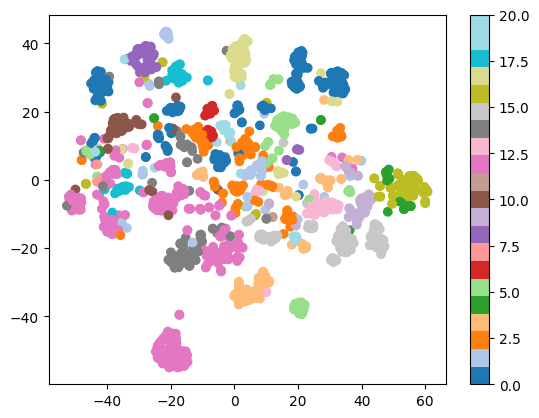

In [31]:
# visualize the embeddings with the sequence ids as the labels (each with its own color)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings)

sequence_ids = [int(imgfn_to_sequence[img_fn]) for img_fn in ids]
individual_ids = []

for seq_id in sequence_ids:
    individual_id = seq_to_id[seq_id]
    individual_ids.append(individual_id)
    
sequence_ids = np.array(sequence_ids)
individual_ids = np.array(individual_ids)
    
print(len(set(individual_ids)))
print(len(individual_ids))


# the sequence ids are not a color, but rather a label. Ensure that the colors have a very broad range, so that the colors are distinct
colors = plt.cm.get_cmap("tab20", len(set(individual_ids)))
individual_ids_num_map = {ind: i for i, ind in enumerate(set(individual_ids))}
c = [individual_ids_num_map[ind] for ind in individual_ids]
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=c, cmap=colors)
plt.colorbar()
# save the plot in high resolution
plt.savefig("/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/embeddings/clustered_embeddings.png", dpi=300)

In [32]:
# Evaluate cluster quality

num_clusters_per_seq = [len(set(cluster_ids)) for cluster_ids in seq_cluster_ids.values()] 
num_clusters_per_individual = [len(set(cluster_ids)) for cluster_ids in iid_cluster_ids.values()]
print("Average number of clusters per sequence: ", np.mean(num_clusters_per_seq))
print("Average number of sequences per cluster: ", np.mean(num_sequences_per_cluster))
print("Average number of clusters per individual: ", np.mean(num_clusters_per_individual))
print("Average number of individuals per cluster: ", np.mean(num_individuals_per_cluster))

print("Number of sequences per cluster")
# for each cluster print num of sequences/total sequences in each cluster
for cluster_id, sequence_ids in sequences_per_cluster.items():
    num_imgs_in_cluster = num_imgs_per_cluster[cluster_id]
    print(f"Cluster {cluster_id}: Containes images from {len(set(sequence_ids))}/{len(sequences)} sequences. Total images in cluster: {num_imgs_in_cluster}")


print("Number of individuals per cluster")
# for each cluster print num of sindivudlas/total individuals in each cluster
for cluster_id, individual_ids in individuals_per_cluster.items():
    num_imgs_in_cluster = num_imgs_per_cluster[cluster_id]
    print(f"Cluster {cluster_id}: Containes images from {len(set(individual_ids))}/{len(set(iid_cluster_ids.keys()))} individuals. Total images in cluster: {num_imgs_in_cluster}")


Average number of clusters per sequence:  2.898876404494382
Average number of sequences per cluster:  12.285714285714286
Average number of individuals per cluster:  7.571428571428571
Average number of clusters per individual:  7.571428571428571
Number of sequences per cluster
Cluster 3: Containes images from 3/89 sequences. Total images in cluster: 66
Cluster 0: Containes images from 9/89 sequences. Total images in cluster: 85
Cluster 1: Containes images from 26/89 sequences. Total images in cluster: 159
Cluster 2: Containes images from 28/89 sequences. Total images in cluster: 108
Cluster 5: Containes images from 17/89 sequences. Total images in cluster: 98
Cluster 9: Containes images from 19/89 sequences. Total images in cluster: 109
Cluster 10: Containes images from 9/89 sequences. Total images in cluster: 86
Cluster 16: Containes images from 22/89 sequences. Total images in cluster: 112
Cluster 18: Containes images from 15/89 sequences. Total images in cluster: 84
Cluster 20: Conta

In [33]:
print("Number of frames per cluster for each sequence")
# for each sequence print num of frames/total frames in each cluster
for sequence_id, cluster_ids in seq_cluster_ids.items():
    cluster_counts = {cluster_id: cluster_ids.count(cluster_id) for cluster_id in set(cluster_ids)}
    # sort by count in descending order
    cluster_counts = dict(sorted(cluster_counts.items(), key=lambda item: item[1], reverse=True))
    print(f"Sequence {sequence_id}: {cluster_counts}")

Number of frames per cluster for each sequence
Sequence 69: {3: 64}
Sequence 50: {10: 23, 16: 15, 0: 4, 1: 4, 5: 2, 2: 1, 9: 1}
Sequence 63: {20: 30, 18: 7, 9: 1, 12: 1}
Sequence 72: {16: 31, 10: 4, 20: 1, 5: 1}
Sequence 65: {9: 62, 20: 8, 18: 6, 6: 2, 16: 2}
Sequence 25: {18: 8, 9: 4, 11: 1, 7: 1}
Sequence 57: {7: 6, 20: 3}
Sequence 62: {2: 5, 16: 4, 10: 2, 18: 1}
Sequence 71: {1: 19, 2: 2, 4: 1, 9: 1}
Sequence 68: {4: 85, 13: 35, 20: 1, 3: 1}
Sequence 58: {16: 28, 1: 11, 5: 3, 6: 2, 2: 1, 9: 1}
Sequence 87: {14: 35}
Sequence 64: {5: 39, 1: 6, 10: 5, 16: 2, 2: 1, 6: 1}
Sequence 39: {19: 39}
Sequence 73: {6: 60, 2: 1}
Sequence 46: {11: 46}
Sequence 75: {8: 27}
Sequence 52: {1: 4, 2: 1, 5: 1}
Sequence 49: {13: 31, 2: 2, 6: 1}
Sequence 66: {1: 14, 5: 8, 9: 3}
Sequence 82: {5: 8, 1: 6, 16: 3, 6: 2, 9: 1, 11: 1}
Sequence 24: {12: 50, 11: 3, 20: 1}
Sequence 30: {0: 35, 7: 1}
Sequence 37: {7: 22}
Sequence 38: {0: 5}
Sequence 26: {18: 45, 9: 4}
Sequence 45: {9: 17, 11: 6, 16: 1}
Sequence 54: 

In [34]:
print("Number of frames from sequence per cluster")
# for each cluster print num of frames/total frames from each sequence in each cluster
for cluster_id, sequence in sequences_per_cluster.items():
    sequence_counts = {sequence_id: seq_cluster_ids[sequence_id].count(cluster_id) for sequence_id in set(sequence)}
    # sort by count in descending order
    sequence_counts = dict(sorted(sequence_counts.items(), key=lambda item: item[1], reverse=True))
    print(f"Cluster {cluster_id}: {sequence_counts}") 

Number of frames from sequence per cluster
Cluster 3: {'69': 64, '60': 1, '68': 1}
Cluster 0: {'30': 35, '32': 24, '17': 7, '74': 5, '38': 5, '50': 4, '76': 2, '84': 2, '86': 1}
Cluster 1: {'71': 19, '51': 18, '40': 18, '66': 14, '3': 11, '58': 11, '15': 9, '54': 8, '79': 6, '2': 6, '82': 6, '64': 6, '52': 4, '50': 4, '28': 3, '8': 3, '33': 3, '77': 2, '67': 1, '13': 1, '85': 1, '9': 1, '10': 1, '23': 1, '1': 1, '60': 1}
Cluster 2: {'55': 16, '70': 14, '47': 13, '80': 9, '78': 6, '5': 6, '79': 5, '42': 5, '62': 5, '88': 4, '27': 3, '22': 2, '41': 2, '49': 2, '71': 2, '53': 2, '28': 1, '52': 1, '83': 1, '51': 1, '50': 1, '33': 1, '73': 1, '58': 1, '32': 1, '29': 1, '64': 1, '56': 1}
Cluster 5: {'64': 39, '51': 14, '67': 11, '66': 8, '82': 8, '58': 3, '50': 2, '47': 2, '22': 2, '41': 2, '79': 1, '54': 1, '52': 1, '18': 1, '20': 1, '34': 1, '72': 1}
Cluster 9: {'65': 62, '45': 17, '47': 5, '26': 4, '25': 4, '66': 3, '18': 2, '63': 1, '22': 1, '79': 1, '4': 1, '51': 1, '50': 1, '71': 1, '5

In [35]:
# Possible next steps: For each cluster, check which sequences represent the same individual to identify how many 
# wrongly placed individuals are in the cluster


In [36]:
# if a sequence is distributed over multiple sequences, compute the how furthest neighbour the cluster is from the other cluster of the same sequence
# fill in the code for the dsrcibed functionality now:

# get centroids of all clusters
cluster_centroids = kmeans.cluster_centers_

cluster_distances = []
for cluster_id, _ in enumerate(cluster_centroids):
    distances = []
    for other_cluster_id, _2 in enumerate(cluster_centroids):
        distance = float(np.linalg.norm(cluster_centroids[cluster_id] - cluster_centroids[other_cluster_id]))
        distances.append(distance)
    cluster_distances.append(sorted(distances))
    
# sort all distances
    
distances = []
distance_counts = []
# for each sequence, find the cluster with the most frames
for sequence_id, cluster_ids in seq_cluster_ids.items():
    cluster_counts = {cluster_id: cluster_ids.count(cluster_id) for cluster_id in set(cluster_ids)}
    max_cluster = max(cluster_counts, key=cluster_counts.get)
    max_cluster_centroid = cluster_centroids[max_cluster]
    for cluster_id in cluster_counts:
        if cluster_id != max_cluster:
            distance = float(np.linalg.norm(max_cluster_centroid - cluster_centroids[cluster_id]))
            k = cluster_distances[max_cluster].index(distance)
            distances.append(k)
            distance_counts.extend([k]*cluster_counts[cluster_id])
            
# print count number smaller 5
print("Number of clusters that are the closest to the cluster of the same sequence: ", len([d for d in distances if d <= 4]))
print("Number of clusters that are not close to the cluster of the same sequence: ", len([d for d in distances if d > 4]))

print(np.mean([d for d in distances if d >5]))
print("Average distance between clusters of the same sequence: ", np.mean(distances))

print("Average distance between clusters of the same sequence (image count): ", np.mean(distance_counts))

Number of clusters that are the closest to the cluster of the same sequence:  73
Number of clusters that are not close to the cluster of the same sequence:  96
10.923076923076923
Average distance between clusters of the same sequence:  6.662721893491124
Average distance between clusters of the same sequence (image count):  5.632034632034632


In [37]:
# if a individual is distributed over multiple clusters, compute the how furthest neighbour the cluster is from the other cluster of the same individual
# fill in the code for the dsrcibed functionality now:

# get centroids of all clusters
cluster_centroids = kmeans.cluster_centers_

cluster_distances = []
for cluster_id, _ in enumerate(cluster_centroids):
    distances = []
    for other_cluster_id, _2 in enumerate(cluster_centroids):
        distance = float(np.linalg.norm(cluster_centroids[cluster_id] - cluster_centroids[other_cluster_id]))
        distances.append(distance)
    cluster_distances.append(sorted(distances))
    
# sort all distances

distances = []
distance_counts = []
# for each individual, find the cluster with the most frames
for iid, cluster_ids in iid_cluster_ids.items():
    cluster_counts = {cluster_id: cluster_ids.count(cluster_id) for cluster_id in set(cluster_ids)}
    max_cluster = max(cluster_counts, key=cluster_counts.get)
    max_cluster_centroid = cluster_centroids[max_cluster]
    for cluster_id in cluster_counts:
        if cluster_id != max_cluster:
            distance = float(np.linalg.norm(max_cluster_centroid - cluster_centroids[cluster_id]))
            k = cluster_distances[max_cluster].index(distance)
            distances.append(k)
            distance_counts.extend([k]*cluster_counts[cluster_id])
            
# print count number smaller 5
print("Number of clusters that are the closest to the cluster of the same individual: ", len([d for d in distances if d <= 4]))
print("Number of clusters that are not close to the cluster of the same individual: ", len([d for d in distances if d > 4]))

print(np.mean([d for d in distances if d >5]))
print("Average distance between clusters of the same individual: ", np.mean(distances))

print("Average distance between clusters of the same individual (image count): ", np.mean(distance_counts))


Number of clusters that are the closest to the cluster of the same individual:  55
Number of clusters that are not close to the cluster of the same individual:  83
11.685714285714285
Average distance between clusters of the same individual:  7.398550724637682
Average distance between clusters of the same individual (image count):  6.603850050658561
